# QFT Equivalence Check: Regular vs DQC

Verify equivalence between regular QFT and DQC QFT circuits using TDD.

In [1]:
import sys
import os
# Add parent directory to path to find TDD2 module
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import time
from qiskit import QuantumCircuit
from TDD2.TDD import Ini_TDD, Index
from TDD2.TDD_Q import cir_2_tn

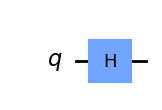

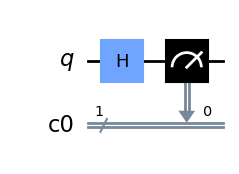

In [2]:
from build_dynamic_qft import build_dynamic_qft
from build_qft import build_qft

# Configuration
QUBITS = 1

# Build circuits
circ_regular = build_qft(QUBITS)
circ_dqc = build_dynamic_qft(QUBITS)

# Draw circuits
display(circ_regular.draw('mpl'))
display(circ_dqc.draw('mpl'))

Circuits Equivalent: True
Regular nodes: 3
DQC nodes: 3
Time: 0.0048s


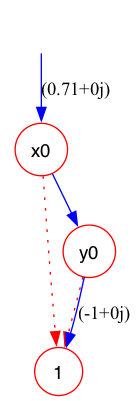

In [3]:
# Load circuits
t_start = time.time()

# Convert to tensor networks
tn_regular, indices = cir_2_tn(circ_regular)
tn_dqc, indices_dqc = cir_2_tn(circ_dqc)

# Rename c indices to y in tn_dqc to match unitary output
for ts in tn_dqc.tensors:
    new_index_set = []
    for idx in ts.index_set:
        if idx.key.startswith('c'):
            # c{k}_0 -> y{k}
            parts = idx.key.split('_')
            k = parts[0][1:] # '1' or '0'
            new_key = 'y' + k
            new_index_set.append(Index(new_key, idx.idx))
        else:
            new_index_set.append(idx)
    ts.index_set = new_index_set

# Update indices list for DQC
indices_dqc_modified = []
for ts in tn_dqc.tensors:
    for idx in ts.index_set:
        if idx.key not in indices_dqc_modified:
            indices_dqc_modified.append(idx.key)

# Merge indices
for idx in indices_dqc_modified:
    if idx not in indices:
        indices.append(idx)

# Initialize TDD and contract
Ini_TDD(indices)
tdd_regular = tn_regular.cont(optimizer='tree_decomposition')[0]
tdd_dqc = tn_dqc.cont(optimizer='tree_decomposition')[0]

# Fix output indices of tdd_dqc (rename y{k} with idx > 0 to idx 0)
new_index_set = []
for idx in tdd_dqc.index_set:
    if idx.key.startswith('y') and idx.idx > 0:
        new_index_set.append(Index(idx.key, 0))
    else:
        new_index_set.append(idx)
tdd_dqc.index_set = new_index_set

# Check equivalence
equivalent = tdd_regular == tdd_dqc
elapsed = time.time() - t_start

print(f"Circuits Equivalent: {equivalent}")
print(f"Regular nodes: {tdd_regular.node_number()}")
print(f"DQC nodes: {tdd_dqc.node_number()}")
print(f"Time: {elapsed:.4f}s")

tdd_regular.show()
# tdd_dqc.show()